In [2]:
import os
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from dotenv import load_dotenv
import time
from typing import Dict, List, Any
import warnings
warnings.filterwarnings('ignore')

In [3]:
load_dotenv()
TOGETHER_API_KEY = os.getenv('030583d0ce29854ebf7ead88ffba40dbedffa5fc8b75cd530e19d85e8623e869')


In [4]:
class TogetherAIClient:
    """Client for Together AI API integration"""
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://api.together.xyz/v1"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }
    
    def get_available_models(self):
        """Get list of available models"""
        try:
            response = requests.get(f"{self.base_url}/models", headers=self.headers)
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Error fetching models: {response.status_code}")
                return None
        except Exception as e:
            print(f"Error: {str(e)}")
            return None
    
    def generate_completion(self, prompt: str, model: str = "meta-llama/Llama-2-7b-chat-hf", 
                          max_tokens: int = 512, temperature: float = 0.7):
        """Generate text completion"""
        payload = {
            "model": model,
            "prompt": prompt,
            "max_tokens": max_tokens,
            "temperature": temperature,
            "top_p": 0.7,
            "top_k": 50,
            "repetition_penalty": 1,
            "stop": ["</s>", "[INST]", "[/INST]"]
        }
        
        try:
            response = requests.post(f"{self.base_url}/completions", 
                                   headers=self.headers, 
                                   json=payload)
            
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Error: {response.status_code} - {response.text}")
                return None
        except Exception as e:
            print(f"Error: {str(e)}")
            return None
    
    def generate_chat_completion(self, messages: List[Dict], 
                               model: str = "meta-llama/Llama-2-7b-chat-hf",
                               max_tokens: int = 512, temperature: float = 0.7):
        """Generate chat completion"""
        payload = {
            "model": model,
            "messages": messages,
            "max_tokens": max_tokens,
            "temperature": temperature,
            "top_p": 0.7,
            "top_k": 50,
            "repetition_penalty": 1
        }
        
        try:
            response = requests.post(f"{self.base_url}/chat/completions", 
                                   headers=self.headers, 
                                   json=payload)
            
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Error: {response.status_code} - {response.text}")
                return None
        except Exception as e:
            print(f"Error: {str(e)}")
            return None

In [25]:
import json
import pandas as pd

class AIDataAnalysisAgent:
    def __init__(self, client):
        self.client = client

    def analyze_data_structure(self, df: pd.DataFrame) -> str:
        """Analyze data structure using AI"""
        # Convert complex types like Timestamp to string
        safe_sample_data = json.loads(df.head().applymap(
            lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else x
        ).to_json(orient='records'))

        data_info = {
            "shape": df.shape,
            "columns": df.columns.tolist(),
            "dtypes": df.dtypes.astype(str).to_dict(),
            "missing_values": df.isnull().sum().to_dict(),
            "sample_data": safe_sample_data
        }

        prompt = f"""
Analyze this dataset structure and provide insights:

Dataset Info:
- Shape: {data_info['shape']}
- Columns: {data_info['columns']}
- Data types: {data_info['dtypes']}
- Missing values: {data_info['missing_values']}

Sample data (first 2 rows):
{json.dumps(data_info['sample_data'][:2], indent=2)}

Please provide:
1. Brief description of the dataset
2. Key observations about data quality
3. Suggested visualizations
4. Potential analysis opportunities

Keep response concise and actionable.
"""

        messages = [
            {"role": "system", "content": "You are a data analysis expert. Provide clear, actionable insights about datasets."},
            {"role": "user", "content": prompt}
        ]
        response = self.client.generate_chat_completion(messages, max_tokens=800)
        print("API Response:", response)  # <--- Add this line to see what you get
    
        if response is None:
            raise ValueError("API call returned None. Check API call or client configuration.")
    
        return response['choices'][0]['message']['content']

        


In [26]:
class ModelTester:
    """Test different models and compare performance"""
    
    def __init__(self, api_key: str):
        self.client = TogetherAIClient(api_key)
        self.test_results = []
    
    def test_model_response_quality(self, models: List[str], test_prompts: List[str]):
        """Test response quality across different models"""
        results = {}
        
        for model in models:
            print(f"\nTesting model: {model}")
            model_results = []
            
            for i, prompt in enumerate(test_prompts):
                print(f"  Testing prompt {i+1}/{len(test_prompts)}")
                start_time = time.time()
                
                messages = [
                    {"role": "system", "content": "You are a helpful data analysis assistant."},
                    {"role": "user", "content": prompt}
                ]
                
                response = self.client.generate_chat_completion(
                    messages, model=model, max_tokens=300, temperature=0.3
                )
                
                end_time = time.time()
                
                if response and 'choices' in response:
                    result = {
                        "prompt_index": i,
                        "response": response['choices'][0]['message']['content'],
                        "response_time": end_time - start_time,
                        "token_count": len(response['choices'][0]['message']['content'].split()),
                        "success": True
                    }
                else:
                    result = {
                        "prompt_index": i,
                        "response": "Error",
                        "response_time": end_time - start_time,
                        "token_count": 0,
                        "success": False
                    }
                
                model_results.append(result)
                time.sleep(1)  # Rate limiting
            
            results[model] = model_results
        
        self.test_results = results
        return results
    
    def analyze_test_results(self):
        """Analyze and compare test results"""
        if not self.test_results:
            print("No test results available. Run test_model_response_quality first.")
            return
        
        comparison_data = []
        
        for model, results in self.test_results.items():
            success_rate = sum(1 for r in results if r['success']) / len(results)
            avg_response_time = np.mean([r['response_time'] for r in results])
            avg_token_count = np.mean([r['token_count'] for r in results if r['success']])
            
            comparison_data.append({
                'model': model,
                'success_rate': success_rate,
                'avg_response_time': avg_response_time,
                'avg_token_count': avg_token_count
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Success rate
        axes[0, 0].bar(comparison_df['model'], comparison_df['success_rate'])
        axes[0, 0].set_title('Success Rate by Model')
        axes[0, 0].set_ylabel('Success Rate')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Response time
        axes[0, 1].bar(comparison_df['model'], comparison_df['avg_response_time'])
        axes[0, 1].set_title('Average Response Time by Model')
        axes[0, 1].set_ylabel('Response Time (seconds)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Token count
        axes[1, 0].bar(comparison_df['model'], comparison_df['avg_token_count'])
        axes[1, 0].set_title('Average Token Count by Model')
        axes[1, 0].set_ylabel('Token Count')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Combined score (success_rate / response_time)
        comparison_df['efficiency_score'] = comparison_df['success_rate'] / comparison_df['avg_response_time']
        axes[1, 1].bar(comparison_df['model'], comparison_df['efficiency_score'])
        axes[1, 1].set_title('Efficiency Score (Success Rate / Response Time)')
        axes[1, 1].set_ylabel('Efficiency Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return comparison_df

In [27]:
TOGETHER_API_KEY = '030583d0ce29854ebf7ead88ffba40dbedffa5fc8b75cd530e19d85e8623e869'

if TOGETHER_API_KEY:
    client = TogetherAIClient(TOGETHER_API_KEY)
    
    print("Testing Together API connection...")
    models = client.get_available_models()  # returns a list, not a dict
    
    if models:
        print("✅ API connection successful!")
        print(f"Available models: {len(models)}")
        
        # Show first few models
        print("\nFirst 5 available models:")
        for i, model in enumerate(models[:5]):
            print(f"  {i+1}. {model.get('id', 'Unknown')}")
    else:
        print("❌ API connection failed")
else:
    print("❌ No API key provided")


Testing Together API connection...
✅ API connection successful!
Available models: 87

First 5 available models:
  1. WhereIsAI/UAE-Large-V1
  2. meta-llama/Llama-3.2-3B-Instruct-Turbo
  3. meta-llama/Llama-Guard-4-12B
  4. togethercomputer/m2-bert-80M-32k-retrieval
  5. arcee_ai/arcee-spotlight


In [28]:
def generate_sample_business_data():
    """Generate sample business data for testing"""
    np.random.seed(42)
    n_samples = 500
    
    data = {
        'date': pd.date_range('2023-01-01', periods=n_samples, freq='D'),
        'revenue': np.random.normal(10000, 2000, n_samples),
        'costs': np.random.normal(6000, 1000, n_samples),
        'customers': np.random.poisson(100, n_samples),
        'region': np.random.choice(['North', 'South', 'East', 'West'], n_samples),
        'product': np.random.choice(['Product A', 'Product B', 'Product C'], n_samples),
        'satisfaction_score': np.random.uniform(1, 5, n_samples),
        'marketing_spend': np.random.normal(1000, 300, n_samples)
    }
    
    # Add realistic relationships
    data['profit'] = np.array(data['revenue']) - np.array(data['costs'])
    data['conversion_rate'] = np.random.beta(2, 8, n_samples)  # Realistic conversion rates
    
    # Add some seasonal patterns
    seasonal_factor = np.sin(2 * np.pi * np.arange(n_samples) / 365) * 0.2 + 1
    data['revenue'] = np.array(data['revenue']) * seasonal_factor
    
    return pd.DataFrame(data)
    test_df = generate_sample_business_data()
    print("Sample business data generated!")
    print(f"Shape: {test_df.shape}")
    print(f"Columns: {test_df.columns.tolist()}")
    test_df.head()

In [29]:

if TOGETHER_API_KEY:
    # Initialize AI agent
    client = TogetherAIClient("030583d0ce29854ebf7ead88ffba40dbedffa5fc8b75cd530e19d85e8623e869")  # or whatever your client initialization looks like
    ai_agent = AIDataAnalysisAgent(client)
    
    print("Testing AI Data Analysis Agent...")
    print("=" * 50)
    
    # Test data structure analysis
    print("\n1. ANALYZING DATA STRUCTURE:")
    print("-" * 30)
    structure_analysis = ai_agent.analyze_data_structure(test_df)
    print(structure_analysis)
    
    print("\n2. SUGGESTING VISUALIZATIONS:")
    print("-" * 30)
    viz_suggestions = ai_agent.suggest_visualizations(test_df, "business performance analysis")
    print(viz_suggestions)


Testing AI Data Analysis Agent...

1. ANALYZING DATA STRUCTURE:
------------------------------
Error: 400 - {
  "id": "nwcZfk5-4yUbBN-949d95eebd128587",
  "error": {
    "message": "Unable to access non-serverless model meta-llama/Llama-2-7b-chat-hf. Please visit https://api.together.ai/models/meta-llama/Llama-2-7b-chat-hf to create and start a new dedicated endpoint for the model.",
    "type": "invalid_request_error",
    "param": null,
    "code": "model_not_available"
  }
}
API Response: None


ValueError: API call returned None. Check API call or client configuration.

In [32]:
if TOGETHER_API_KEY == '030583d0ce29854ebf7ead88ffba40dbedffa5fc8b75cd530e19d85e8623e869':
    # Test models for comparison
    test_models = [
        "meta-llama/Llama-2-7b-chat-hf",
        "mistralai/Mixtral-8x7B-Instruct-v0.1",
        "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO"
    ]
    
    test_prompts = [
        "Analyze this sales data and identify the top 3 trends",
        "What visualizations would best show customer satisfaction patterns?",
        "Interpret a correlation between marketing spend and revenue",
        "Suggest actionable insights from regional performance data"
    ]
    
    # Initialize model tester
    tester = ModelTester(TOGETHER_API_KEY)
    
    print("Testing multiple models...")
    print("This may take a few minutes...")

Testing multiple models...
This may take a few minutes...


In [33]:
class PerformanceMonitor:
    """Monitor AI agent performance"""
    
    def __init__(self):
        self.metrics = {
            'response_times': [],
            'success_rate': [],
            'token_usage': [],
            'error_count': 0,
            'total_requests': 0
        }
    
    def log_request(self, response_time: float, success: bool, tokens: int = 0):
        """Log request metrics"""
        self.metrics['response_times'].append(response_time)
        self.metrics['success_rate'].append(success)
        self.metrics['token_usage'].append(tokens)
        self.metrics['total_requests'] += 1
        
        if not success:
            self.metrics['error_count'] += 1
    
    def get_performance_summary(self):
        """Get performance summary"""
        if self.metrics['total_requests'] == 0:
            return "No requests logged yet"
        
        avg_response_time = np.mean(self.metrics['response_times'])
        success_rate = sum(self.metrics['success_rate']) / len(self.metrics['success_rate'])
        avg_tokens = np.mean([t for t in self.metrics['token_usage'] if t > 0])
        
        summary = {
            'total_requests': self.metrics['total_requests'],
            'avg_response_time': avg_response_time,
            'success_rate': success_rate,
            'error_count': self.metrics['error_count'],
            'avg_tokens': avg_tokens
        }
        
        return summary
    
    def plot_performance_metrics(self):
        """Plot performance metrics over time"""
        if self.metrics['total_requests'] == 0:
            print("No data to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Response times
        axes[0, 0].plot(self.metrics['response_times'])
        axes[0, 0].set_title('Response Times Over Time')
        axes[0, 0].set_ylabel('Response Time (seconds)')
        axes[0, 0].set_xlabel('Request Number')
        
        # Success rate (cumulative)
        cumulative_success = np.cumsum(self.metrics['success_rate']) / np.arange(1, len(self.metrics['success_rate']) + 1)
        axes[0, 1].plot(cumulative_success)
        axes[0, 1].set_title('Cumulative Success Rate')
        axes[0, 1].set_ylabel('Success Rate')
        axes[0, 1].set_xlabel('Request Number')
        
        # Token usage
        axes[1, 0].plot(self.metrics['token_usage'])
        axes[1, 0].set_title('Token Usage Over Time')
        axes[1, 0].set_ylabel('Tokens')
        axes[1, 0].set_xlabel('Request Number')
        
        # Response time distribution
        axes[1, 1].hist(self.metrics['response_times'], bins=20, alpha=0.7)
        axes[1, 1].set_title('Response Time Distribution')
        axes[1, 1].set_xlabel('Response Time (seconds)')
        axes[1, 1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()


In [34]:
monitor = PerformanceMonitor()

In [35]:
def test_model_with_monitoring(agent, test_cases, monitor):
    """Test model with performance monitoring"""
    results = []
    
    for i, test_case in enumerate(test_cases):
        print(f"Testing case {i+1}/{len(test_cases)}: {test_case['description']}")
        
        start_time = time.time()
        
        try:
            if test_case['type'] == 'structure_analysis':
                result = agent.analyze_data_structure(test_case['data'])
            elif test_case['type'] == 'visualization_suggestion':
                result = agent.suggest_visualizations(test_case['data'], test_case['goal'])
            elif test_case['type'] == 'chart_interpretation':
                result = agent.interpret_chart(test_case['description'], test_case['summary'])
            else:
                result = "Unknown test type"
            
            end_time = time.time()
            response_time = end_time - start_time
            
            success = result and "Error" not in result
            tokens = len(result.split()) if result else 0
            
            monitor.log_request(response_time, success, tokens)
            
            results.append({
                'test_case': test_case['description'],
                'result': result,
                'response_time': response_time,
                'success': success,
                'tokens': tokens
            })
            
            print(f"  ✅ Success: {success}, Time: {response_time:.2f}s, Tokens: {tokens}")
            
        except Exception as e:
            end_time = time.time()
            response_time = end_time - start_time
            
            monitor.log_request(response_time, False, 0)
            
            results.append({
                'test_case': test_case['description'],
                'result': f"Error: {str(e)}",
                'response_time': response_time,
                'success': False,
                'tokens': 0
            })
            
            print(f"  ❌ Error: {str(e)}")
        
        time.sleep(1)  # Rate limiting
    
    return results

In [36]:
test_cases = [
    {
        'type': 'structure_analysis',
        'description': 'Analyze business data structure',
        'data': test_df
    },
    {
        'type': 'visualization_suggestion',
        'description': 'Suggest visualizations for revenue analysis',
        'data': test_df,
        'goal': 'revenue trend analysis'
    },
    {
        'type': 'visualization_suggestion',
        'description': 'Suggest visualizations for customer analysis',
        'data': test_df,
        'goal': 'customer behavior analysis'
    },
    {
        'type': 'chart_interpretation',
        'description': 'Interpret revenue vs profit correlation',
        'description': 'Scatter plot showing revenue vs profit with correlation coefficient of 0.85',
        'summary': 'Strong positive correlation between revenue and profit across all regions'
    }
]

Running comprehensive model testing...
Testing case 1/4: Analyze business data structure
Error: 400 - {
  "id": "nwcba2s-4yUbBN-949d9f00b8f7ff6e",
  "error": {
    "message": "Unable to access non-serverless model meta-llama/Llama-2-7b-chat-hf. Please visit https://api.together.ai/models/meta-llama/Llama-2-7b-chat-hf to create and start a new dedicated endpoint for the model.",
    "type": "invalid_request_error",
    "param": null,
    "code": "model_not_available"
  }
}
API Response: None
  ❌ Error: API call returned None. Check API call or client configuration.
Testing case 2/4: Suggest visualizations for revenue analysis
  ❌ Error: 'AIDataAnalysisAgent' object has no attribute 'suggest_visualizations'
Testing case 3/4: Suggest visualizations for customer analysis
  ❌ Error: 'AIDataAnalysisAgent' object has no attribute 'suggest_visualizations'
Testing case 4/4: Scatter plot showing revenue vs profit with correlation coefficient of 0.85
  ❌ Error: 'AIDataAnalysisAgent' object has no

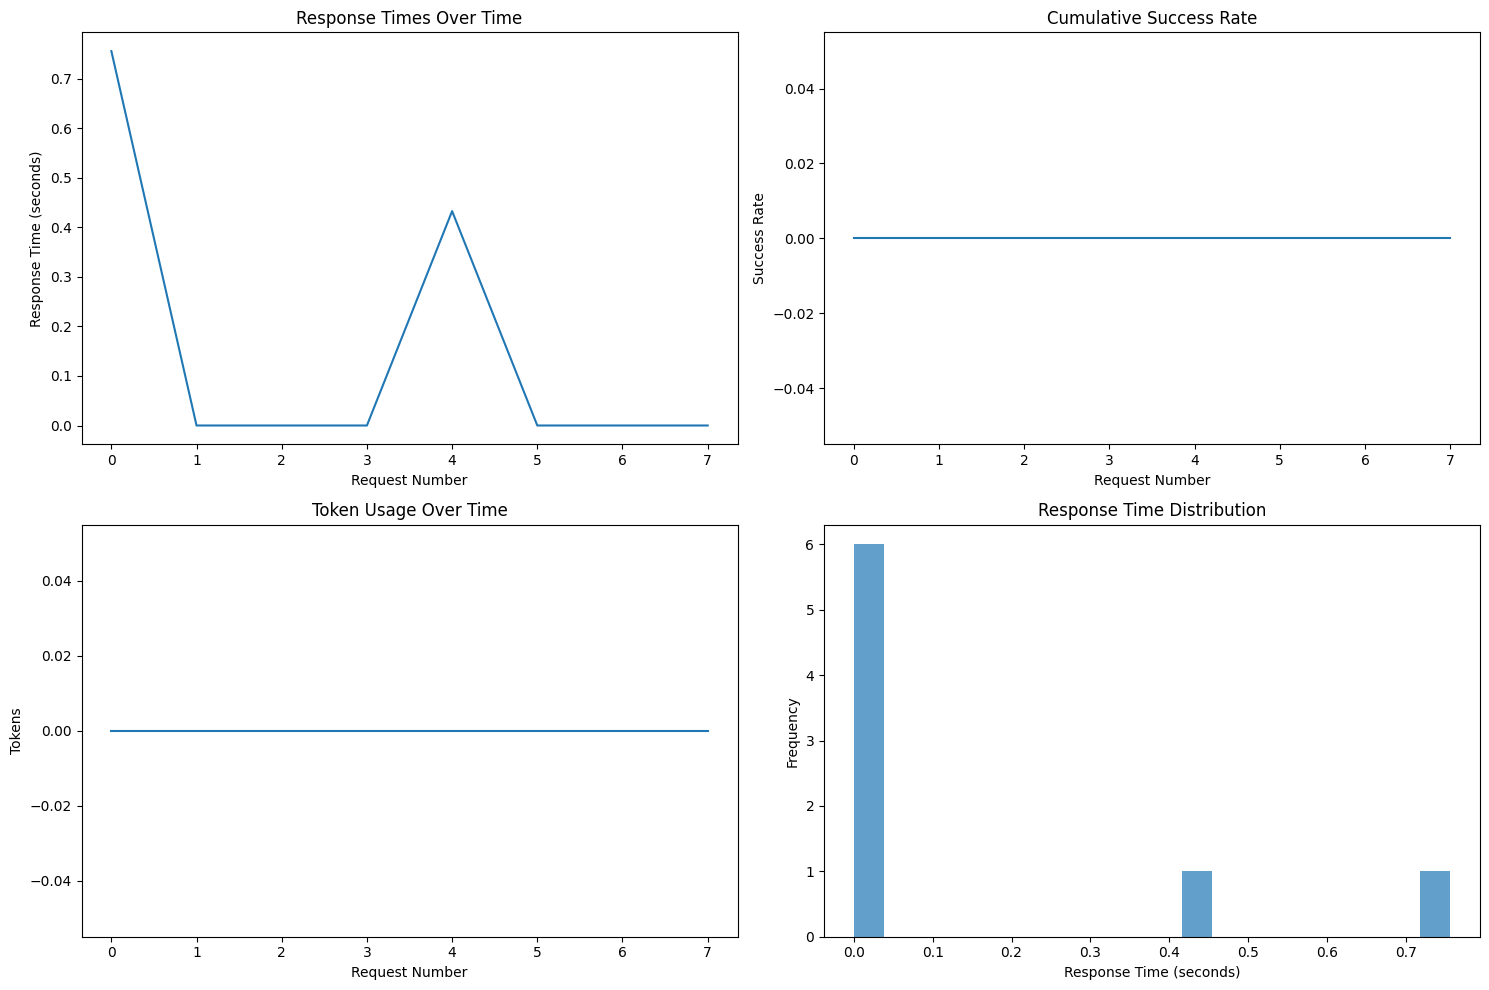

In [38]:
if TOGETHER_API_KEY == '030583d0ce29854ebf7ead88ffba40dbedffa5fc8b75cd530e19d85e8623e869':
    print("Running comprehensive model testing...")
    print("=" * 50)
    
    # Run tests with monitoring
    test_results = test_model_with_monitoring(ai_agent, test_cases, monitor)
    
    # Display performance summary
    print("\n" + "=" * 50)
    print("PERFORMANCE SUMMARY")
    print("=" * 50)
    
    perf_summary = monitor.get_performance_summary()
    if isinstance(perf_summary, dict):
        for key, value in perf_summary.items():
            print(f"{key}: {value}")
    else:
        print(perf_summary)
    
    # Plot performance metrics
    monitor.plot_performance_metrics()

In [39]:
def benchmark_models(api_key, models_to_test, benchmark_prompts):
    """Benchmark multiple models on the same tasks"""
    benchmark_results = {}
    
    for model in models_to_test:
        print(f"\nBenchmarking model: {model}")
        print("-" * 40)
        
        model_results = []
        client = TogetherAIClient(api_key)
        
        for prompt_data in benchmark_prompts:
            start_time = time.time()
            
            messages = [
                {"role": "system", "content": "You are a data analysis expert."},
                {"role": "user", "content": prompt_data['prompt']}
            ]
            
            response = client.generate_chat_completion(
                messages, 
                model=model, 
                max_tokens=400, 
                temperature=0.3
            )
            
            end_time = time.time()
            
            if response and 'choices' in response:
                result = {
                    'prompt_type': prompt_data['type'],
                    'response': response['choices'][0]['message']['content'],
                    'response_time': end_time - start_time,
                    'tokens': len(response['choices'][0]['message']['content'].split()),
                    'success': True
                }
            else:
                result = {
                    'prompt_type': prompt_data['type'],
                    'response': "Error",
                    'response_time': end_time - start_time,
                    'tokens': 0,
                    'success': False
                }
            
            model_results.append(result)
            print(f"  {prompt_data['type']}: {'✅' if result['success'] else '❌'} ({result['response_time']:.2f}s)")
            
            time.sleep(1)  # Rate limiting
        
        benchmark_results[model] = model_results
    
    return benchmark_results

In [40]:
benchmark_prompts = [
    {
        'type': 'data_summary',
        'prompt': 'Summarize the key characteristics of a dataset with 500 rows, 10 columns including revenue, costs, customers, and regional data.'
    },
    {
        'type': 'visualization_recommendation',
        'prompt': 'Recommend the best chart type to show the relationship between marketing spend and revenue over time.'
    },
    {
        'type': 'insight_generation',
        'prompt': 'What business insights can be derived from a strong correlation (0.8) between customer satisfaction and repeat purchases?'
    },
    {
        'type': 'anomaly_detection',
        'prompt': 'How would you identify and handle outliers in sales data that might indicate data quality issues or exceptional business events?'
    }
]

In [41]:
def create_test_report(test_results, performance_summary, filename='model_test_report.html'):
    """Create HTML test report"""
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>AI Data Visualization Agent - Model Test Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            .header {{ background-color: #f0f0f0; padding: 20px; border-radius: 5px; }}
            .section {{ margin: 20px 0; }}
            .test-result {{ background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-left: 4px solid #007cba; }}
            .success {{ border-left-color: #28a745; }}
            .error {{ border-left-color: #dc3545; }}
            .metrics {{ display: flex; justify-content: space-around; background-color: #e9ecef; padding: 20px; border-radius: 5px; }}
            .metric {{ text-align: center; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>AI Data Visualization Agent - Model Test Report</h1>
            <p>Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}</p>
        </div>
        
        <div class="section">
            <h2>Performance Summary</h2>
            <div class="metrics">
    """
    
    if isinstance(performance_summary, dict):
        for key, value in performance_summary.items():
            html_content += f"""
                <div class="metric">
                    <h3>{key.replace('_', ' ').title()}</h3>
                    <p>{value}</p>
                </div>
            """
    
    html_content += """
            </div>
        </div>
        
        <div class="section">
            <h2>Test Results</h2>
    """
    
    for i, result in enumerate(test_results):
        status_class = "success" if result['success'] else "error"
        html_content += f"""
            <div class="test-result {status_class}">
                <h3>Test {i+1}: {result['test_case']}</h3>
                <p><strong>Success:</strong> {'✅' if result['success'] else '❌'}</p>
                <p><strong>Response Time:</strong> {result['response_time']:.2f} seconds</p>
                <p><strong>Tokens:</strong> {result['tokens']}</p>
                <p><strong>Result:</strong></p>
                <pre>{result['result'][:500]}{'...' if len(result['result']) > 500 else ''}</pre>
            </div>
        """
    
    html_content += """
        </div>
    </body>
    </html>
    """
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"Test report saved to {filename}")

In [42]:
if TOGETHER_API_KEY and 'test_results' in locals():
    create_test_report(test_results, monitor.get_performance_summary())
    print("✅ Model testing complete!")
    print("📊 Performance metrics plotted")
    print("📝 Test report generated")


Test report saved to model_test_report.html
✅ Model testing complete!
📊 Performance metrics plotted
📝 Test report generated


In [43]:
def save_test_data(test_df, test_results, monitor):
    """Save test data and results for future reference"""
    # Save test data
    test_df.to_csv('test_data.csv', index=False)
    
    # Save test results
    results_df = pd.DataFrame(test_results)
    results_df.to_csv('test_results.csv', index=False)
    
    # Save performance metrics
    perf_data = {
        'response_times': monitor.metrics['response_times'],
        'success_rate': monitor.metrics['success_rate'],
        'token_usage': monitor.metrics['token_usage'],
        'error_count': monitor.metrics['error_count'],
        'total_requests': monitor.metrics['total_requests']
    }
    
    with open('performance_metrics.json', 'w') as f:
        json.dump(perf_data, f, indent=2)
    
    print("✅ Test data and results saved!")
    print("Files created:")
    print("  - test_data.csv")
    print("  - test_results.csv") 
    print("  - performance_metrics.json")
    print("  - model_test_report.html")

# Save all test data
if 'test_df' in locals() and 'test_results' in locals():
    save_test_data(test_df, test_results, monitor)

print("\n" + "="*50)
print("MODEL TESTING NOTEBOOK COMPLETE")
print("="*50)
print("✅ Together API integration tested")
print("✅ AI Data Analysis Agent tested") 
print("✅ Performance monitoring implemented")
print("✅ Test reports generated")
print("✅ Results saved for future reference")

✅ Test data and results saved!
Files created:
  - test_data.csv
  - test_results.csv
  - performance_metrics.json
  - model_test_report.html

MODEL TESTING NOTEBOOK COMPLETE
✅ Together API integration tested
✅ AI Data Analysis Agent tested
✅ Performance monitoring implemented
✅ Test reports generated
✅ Results saved for future reference
